In [1]:
import pandas as pd
import numpy as np
import joblib

# Reading the data

In [2]:
model_df = pd.read_pickle("../SavedData/model_df.pkl")

In [3]:
model_df.head()

,season,team_id_for,team_id_against,event,period,periodTime,st_x,st_y
0,2010,8,10,Shot,1,86,81,-7
1,2010,8,10,Shot,1,1092,45,-23
2,2010,10,8,Missed Shot,1,1120,37,-21
3,2010,10,8,Shot,1,1151,48,-30
4,2010,10,8,Missed Shot,1,1186,1,1


In [4]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062526 entries, 0 to 1062525
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   season           1062526 non-null  int64 
 1   team_id_for      1062526 non-null  int64 
 2   team_id_against  1062526 non-null  int64 
 3   event            1062526 non-null  object
 4   period           1062526 non-null  int64 
 5   periodTime       1062526 non-null  int64 
 6   st_x             1062526 non-null  int64 
 7   st_y             1062526 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 64.9+ MB


In [5]:
# Get features and target
X = model_df.drop("event", axis=1)
y = model_df["event"]

# Reading GridSearch results

In [7]:
df_grid = pd.read_pickle('../SavedModels/grid_results.pkl')

In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
df_grid

,params,mean_test_score,rank_test_score
0,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 15}",0.353125,61
1,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 20}",0.351628,75
2,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 25}",0.350959,77
3,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 30}",0.352224,67
4,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 35}",0.352188,68
...,...,...,...
75,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 15}",0.516880,20
76,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 20}",0.521694,19
77,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 25}",0.526034,18
78,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 30}",0.529156,17


In [10]:
df_grid.sort_values("rank_test_score", ascending=True)

,params,mean_test_score,rank_test_score
64,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 35}",0.585611,1
63,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 30}",0.582798,2
62,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 25}",0.579789,3
61,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 20}",0.574728,4
60,"{'clf__max_depth': 25, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 15}",0.568535,5
...,...,...,...
15,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 15}",0.351382,76
2,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 25}",0.350959,77
6,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 20}",0.350384,78
10,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 15}",0.349608,79


# Evaluating our best model

Let's set aside some data for validation (test set). We'll do our cross validation using only the training data and use the test data for reporting.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
# Preprocessing
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model
from sklearn.ensemble import RandomForestClassifier

# set up preprocessing for numeric columns
scaler = StandardScaler()

# set up preprocessing for categorical columns
ohe = OneHotEncoder()

# select columns by data type
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# Build categorical preprocessor
categorical_pipe = make_pipeline(ohe)

# Build numeric processor
numeric_pipe = make_pipeline(scaler)

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, cat_cols),
        ("numeric", numeric_pipe, num_cols),
    ]
)

# Tuned model
model = RandomForestClassifier(
    n_estimators=35, min_samples_leaf=1, max_depth=25, class_weight="balanced"
)

# Final pipeline combined with model
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        ("clf", model),
    ]
)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

## F1 metric

In [15]:
f1 = make_scorer(f1_score, average="weighted")

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

scores = cross_val_score(pipeline, X_train, y_train, scoring=(f1), cv=cv)

In [16]:
scores

array([0.55146425, 0.55220989, 0.5509473 , 0.54945221, 0.5520434 ,
       0.55265993, 0.55079002, 0.55114421, 0.55034635, 0.55214663,
       0.5520726 , 0.55174809, 0.55058145, 0.55214759, 0.54998288])

In [17]:
scores.mean()

0.5513157871625068

## Fitting the model to train data

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fde88cf60d0>),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fde85a4e810>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=25,
                                        n_estimators=35))])

## Classification report

In [19]:
from sklearn.metrics import classification_report

In [20]:
# Classification reports - train
train_preds = pipeline.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

        Goal       0.62      0.99      0.76     57286
 Missed Shot       0.97      0.95      0.96    236366
        Shot       0.99      0.94      0.96    556368

    accuracy                           0.95    850020
   macro avg       0.86      0.96      0.90    850020
weighted avg       0.96      0.95      0.95    850020



In [21]:
# Classification reports - test
test_preds = pipeline.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

        Goal       0.17      0.20      0.18     14322
 Missed Shot       0.33      0.16      0.21     59092
        Shot       0.67      0.80      0.73    139092

    accuracy                           0.58    212506
   macro avg       0.39      0.39      0.38    212506
weighted avg       0.54      0.58      0.55    212506



In [22]:
# Evaluating base model
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def confusion_plot(model, X, y):
    """ """
    y_pred = model.predict(X)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the matrix
    cm = confusion_matrix(y, y_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=70)

    ax.grid(False)
    plt.show();

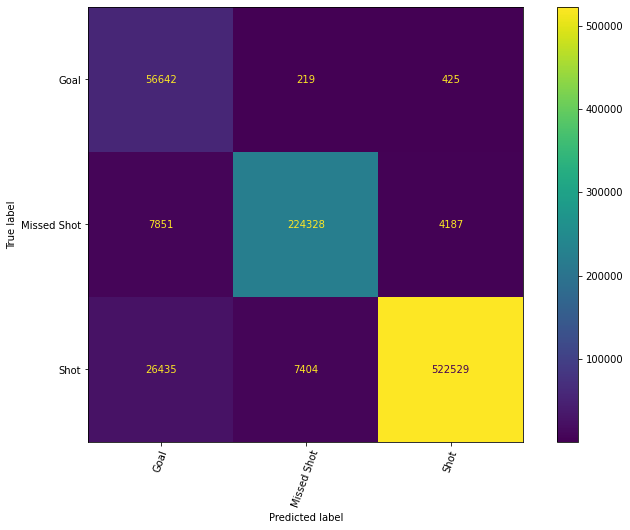

In [23]:
confusion_plot(pipeline, X_train, y_train)

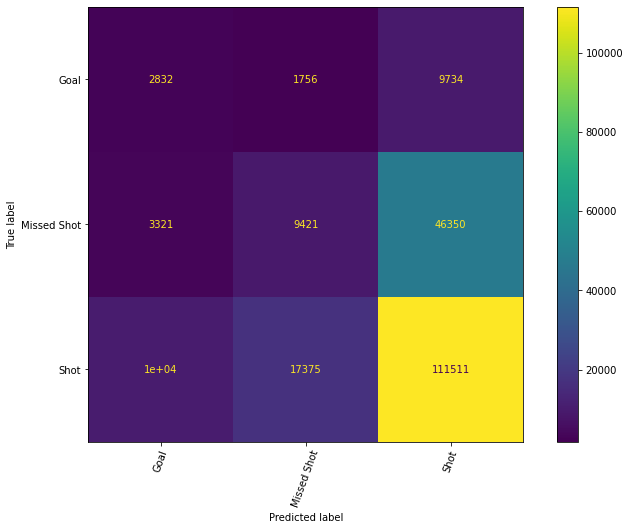

In [24]:
confusion_plot(pipeline, X_test, y_test)

We can make this confusion matrix a bit more informative:
* In the call to the `confusion_matrix()` method, we add the argument `normalize='true'` to get the values normalized over the true values.
* In the call to the `ConfusionMatrixDisplay()` method we multiply our `cm` by 100 to get the annotations as percentage.

In [25]:
def confusion_plot(model, X, y):
    """
    """
    y_pred = model.predict(X)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the matrix
    cm = confusion_matrix(y, y_pred, normalize='true')
    cmp = ConfusionMatrixDisplay(cm*100, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=70)

    ax.grid(False)
    plt.show();

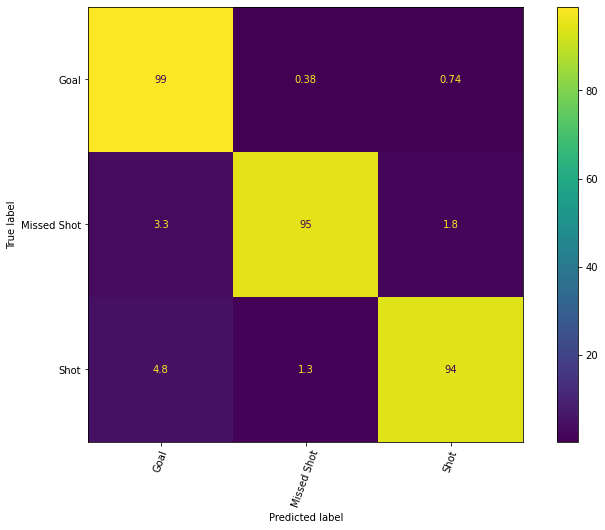

In [26]:
confusion_plot(pipeline, X_train, y_train)

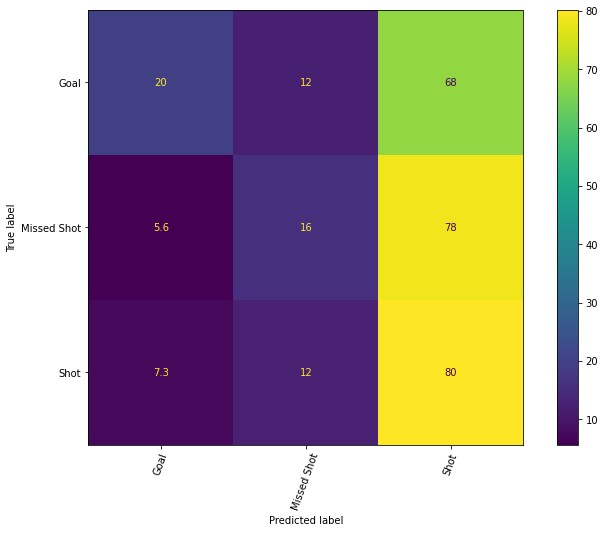

In [27]:
confusion_plot(pipeline, X_test, y_test)

Wow, that's a hard task!